<a href="https://colab.research.google.com/github/shubham13596/Stanford-CS224S/blob/main/Homework2_CS224S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

> DUPLICATE THIS COLAB TO START WORKING ON IT. Using File > Save a copy to drive.

# Synthesizing speech and working with raw transcripts

CS224S / LINGUIST285: Spoken Language Processing. 2025. Homework 2 Notebook.

In this assignment, you will experiment with speech synthesis and voice cloning models. You will also gain experience working with speech transcripts by converting raw transcripts into more useful, clean summaries. As a reminder, please only create voice cloning samples from someone **if you have their permission!** Using speech samples from TTS training datasets is okay too.

The assignment is worth 165 points in total. Submit your solutions via gradescrope. We do not require you to submit audio files, only the visualizations, text output files, and notebook output from your work.


# Section 1: Transforming ASR transcripts into useful summaries (45 points total)

If you build products that leverage speech recognition, you are likely to encounter longer, messier transcripts than what we find in research datasets. Spoken transcripts contain filler words, sentence re-starts, and transcription mistakes which makes the raw form of the transcript difficult to read or understand as text. Let's do some experiments on transcripts to explore how you might post-process a raw transcript for downstream NLProc or product needs.

**Building a product MVP: Automatic lecture notes**

In this section let's imagine you're developing a new product idea: a service which converts lecture recordings into lecture notes for courses like CS224S! To develop such a product, we need to understand de-risk the step of converting Zoom transcripts into useful notes and summaries. We do not need to build a perfect system in our first approach. Instead let's try a quick experiment to learn about the feasibility of using some basic text cleanup and LLMs as a means to create lecture notes from transcripts.

In the next sections, you will:

We provide a basic LLM setup and raw transcripts from a few CS224S lectures. Your ultimate task is to create a heuristic for converting a zoom lecture into a set of summarizied "lecture notes" with bullet points of main topics and takeaways from lecture.

## Loading raw transcripts

We will use the actual transcript files produced by Zoom for a few lectures from CS224S this year. The raw transcripts are available on [Google Drive](https://drive.google.com/drive/folders/1VKLQ71PmVDpUIQXklYe0Yy7OpUjCbCbZ)

Sample code to download the files and read the Vtt is also given

In [ ]:
!pip install gdown
!gdown https://drive.google.com/drive/folders/1bslZ5mTq71bg5rhan0B06oDr93U28Vp8?usp=sharing -O ./lecture_notes --folder

Retrieving folder contents
Processing file 1R5bXbXfC4SNDmwVkzoC5PJDliS4Cn4BE 224S_2024_lec_17_raw.txt
Processing file 1iEILDaZPxEERYVk_Lq7nVZ-PdtDgnPQX 224S_2025_lec_2_raw.txt
Processing file 1CQOohUr7Kyy1ddS8he2WyBXiYiIx_PT8 CS224S_2024_lec_2.vtt
Processing file 1QsM7yYUGBdX_ObqlYtoZjdb9405JT2aA CS224S_2024_lec_3.vtt
Processing file 17jD8H7uRJR7wfCiJrE7DyitdGxrg9Ypm CS224S_2024_lec_4.vtt
Processing file 1njYx-_IudLPX3OcbICqNgJcM0ZY-GlGQ CS224S_2025_lec_3_raw.txt
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1R5bXbXfC4SNDmwVkzoC5PJDliS4Cn4BE
To: /content/lecture_notes/224S_2024_lec_17_raw.txt
100% 69.6k/69.6k [00:00<00:00, 3.88MB/s]
Downloading...
From: https://drive.google.com/uc?id=1iEILDaZPxEERYVk_Lq7nVZ-PdtDgnPQX
To: /content/lecture_notes/224S_2025_lec_2_raw.txt
100% 62.5k/62.5k [00:00<00:00, 2.53MB/s]
Downloading...
From: https://drive.google.com/uc?id=1CQOohUr7Kyy1ddS8h

In [ ]:
def load_vtt(file_path):
  return open(file_path).read()


# 2024 lectures -- You do not have access to original video
lec_2_2024 = load_vtt("lecture_notes/CS224S_2024_lec_2.vtt")
lec_3_2024 = load_vtt("lecture_notes/CS224S_2024_lec_3.vtt")
lec_4_2024 = load_vtt("lecture_notes/CS224S_2024_lec_4.vtt")
lec_17_2024 = load_vtt("lecture_notes/224S_2024_lec_17_raw.txt")

# 2025 lectures -- You may check the original video on Canvas as a reference
lec_2_2025 = load_vtt("lecture_notes/224S_2025_lec_2_raw.txt")
lec_3_2025 = load_vtt("lecture_notes/CS224S_2025_lec_3_raw.txt")


### Task: Strip extra text (5 points)

You'll notice that lines in the `.vtt` files are not all transcripts. There is a very regular structure which includes line number and speaker ID, e.g.
```
12
00:01:14.284 --> 00:01:18.289
Andrew Maas: remember, the course project Handout is up on the website
```
Your task, for each lecture (file) we loaded, is to create a **transcript-only** version containing only transcript text with extra information removed. Remove line number, timings, and the speaker's name.

Eg:-
```
remember, the course project Handout is up on the website
```

In [ ]:
import regex as re
def filter_data(vtt_file_text: str) -> str:
  #############################
  #### YOUR CODE GOES HERE ####

  blocks = (vtt_file_text.split('\n\n'))
  transcript_only = []
  for block in blocks:
    block = block.strip()
    if not block:
      continue
    if block == 'WEBVTT' or block.startswith('NOTE '):
      continue
    lines = block.split('\n')
    if len(lines) <=2 and (
        re.match(r'^\d+$', lines[0]) if lines else False or
        ('-->' in lines[0] if lines else False)
    ):
      continue

    transcript_start_idx = -1
    for i, line in enumerate(lines):
      if '-->' in line:
        transcript_start_idx = i + 1
        break

    if transcript_start_idx > 0 and transcript_start_idx < len(lines):
      # Get all transcript lines in this cue
      transcript_lines = lines[transcript_start_idx:]

      # Join multi-line transcripts into a single line
      cue_text = ''
      for line in transcript_lines:
        line = line.strip()
        if line:
        # Handle speaker prefix (Name: transcript)
          if ': ' in line:
            parts = line.split(': ', 1)
            transcript = parts[1].strip()
            if transcript:
            # Only add non-empty transcripts
              cue_text += (' ' if cue_text else '') + transcript
            elif not re.match(r'^[A-Za-z\s]+:$', line):
              # Add line if it's not just a speaker name with colon
              cue_text += (' ' if cue_text else '') + line

        if cue_text:
          transcript_only.append(cue_text)

  return '\n'.join(transcript_only)



# 2024 lectures
filtered_lec_2_2024 = filter_data(lec_2_2024)
filtered_lec_3_2024 = filter_data(lec_3_2024)
filtered_lec_4_2024 = filter_data(lec_4_2024)
filtered_lec_17_2024 = filter_data(lec_17_2024)

# 2025 lectures
filtered_lec_2_2025 = filter_data(lec_2_2025)
filtered_lec_3_2025 = filter_data(lec_3_2025)

#############################

In [ ]:
filtered_lec_4_2024

"Alright. So our lecture recording is going.\nI'm\noh, I have to turn this thing on.\nHow's that?\nI should be audible? Okay, if you can't hear me. I can turn this up, but I think this is good enough.\nand quick stuff. We have\noffice hours this week. This will be our kind of regular schedule. We'll put it up on the website. We're just sort of testing it this week.\nbut in particular, because there's\nask on Ed for additional office hours over the weekend sometime\nwe're more than happy to do some like calendly zoom setup.\nso that on Saturday or Sunday people can ask some questions on the homework if you're unable to like finish stuff, and you have questions before the final office hours that's lifted here, which is Thursday.\nremember, the course project Handout is up on the website\non Monday. We will spend lecture time talking about course projects. We have some kind of examples of good projects\nstuff to think about when you're planning a project and picking a team and we also hav

## LLM setup

Large language models (LLMs) are an incredibly useful tool for _text reformatting_ where we convert text to a different written style, or create summarizations. We expect LLMs to be a helpful tool in rapid prototyping of our transcript to notes system.



Before continuing, ensure the notebook runtime is set to T4 GPU

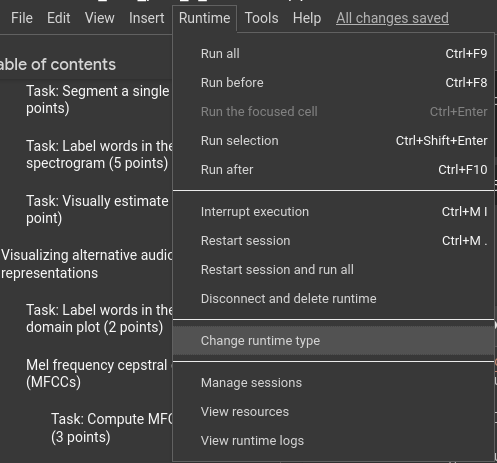

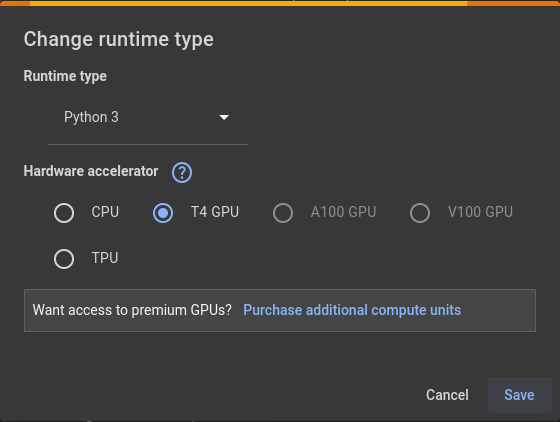

### VLLM

Below we load a model which you can run using the GPU in Colab without the need to set up another API key. You may use any LLM (e.g., ChatGPT, Claude, Gemini, Llama), but please submit the LLM used along with a brief description of your prompting and workflow when you are asked to describe your approach.

The LLM used below is a [Llama-2 13B model from HuggingFace](https://huggingface.co/TheBloke/Llama-2-13B-chat-GPTQ)


In [ ]:
!pip install vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.4/326.4 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 70.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 MB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 108.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 118.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 66.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5

**WARNING: YOU MUST RESTART YOUR RUNTIME MANUALLY AFTER RUNNING THE ABOVE.**
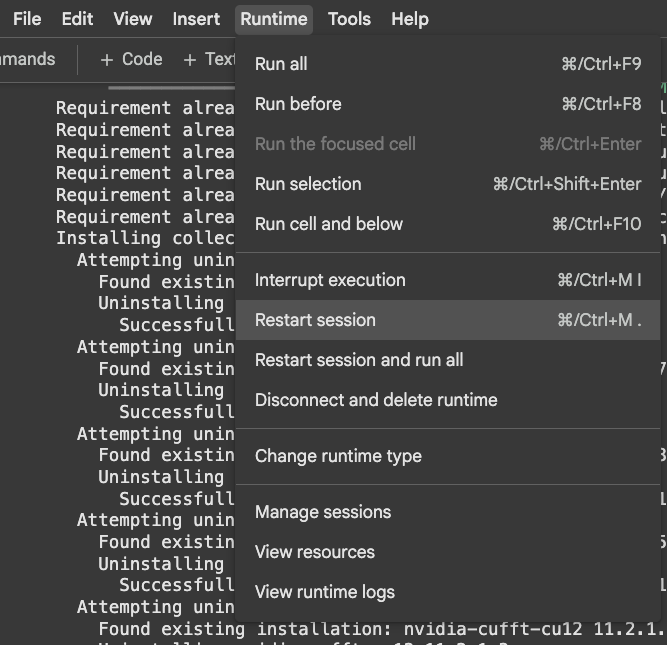

In [ ]:
!pip install bitblas>=0.1.0

In [ ]:
# This demonstrates how to sample from the LLM and verifies it works for you
from vllm import LLM, SamplingParams

# Sample prompts.
prompts = [
    "Hello, my name is",
    "The president of the United States is",
    "The capital of France is",
    "The future of AI is",
]
# Create a sampling params object.
sampling_params = SamplingParams(temperature=0.8, top_p=0.95)

# Create an LLM.
llm = LLM(model="TheBloke/Llama-2-13B-chat-GPTQ", gpu_memory_utilization=0.8)
# Generate texts from the prompts. The output is a list of RequestOutput objects
# that contain the prompt, generated text, and other information.

outputs = llm.generate(prompts, sampling_params)

# Print the outputs.
for output in outputs:
    prompt = output.prompt
    generated_text = output.outputs[0].text
    print(f"Prompt: {prompt!r}, Generated text: {generated_text!r}")

INFO 05-26 01:58:23 [__init__.py:239] Automatically detected platform cuda.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


INFO 05-26 01:58:43 [config.py:717] This model supports multiple tasks: {'score', 'embed', 'classify', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 05-26 01:58:44 [gptq_bitblas.py:164] The model is convertible to gptq_bitblas during runtime. Using gptq_bitblas kernel.
WARNING 05-26 01:58:44 [arg_utils.py:1658] Compute Capability < 8.0 is not supported by the V1 Engine. Falling back to V0. 
INFO 05-26 01:58:45 [llm_engine.py:240] Initializing a V0 LLM engine (v0.8.5.post1) with config: model='TheBloke/Llama-2-13B-chat-GPTQ', speculative_config=None, tokenizer='TheBloke/Llama-2-13B-chat-GPTQ', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=4096, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=gptq_bitblas, enforce_eager=False, kv_cache_dtype=auto,  device_con

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


INFO 05-26 01:58:46 [cuda.py:240] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 05-26 01:58:46 [cuda.py:289] Using XFormers backend.
INFO 05-26 01:58:47 [parallel_state.py:1004] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, TP rank 0
INFO 05-26 01:58:47 [model_runner.py:1108] Starting to load model TheBloke/Llama-2-13B-chat-GPTQ...
INFO 05-26 01:58:47 [gptq_bitblas.py:297] Using BitBLASLinearKernel for GPTQBitBLASLinearMethod
2025-05-26 01:58:47 [BitBLAS:WARNING]: TVM target not found. Please set the TVM target environment variable using `export TVM_TARGET=<target>`, where <target> is one of the available targets can be found in the output of `tools/get_available_targets.py`.
2025-05-26 02:00:57 [BitBLAS:ERROR]: An exception occurred for hint {block_M=16,block_N=48,block_K=160,num_stages=0,threads=96,enable_rasterization=False}: Traceback (most recent call last):
  71: tvm::runtime::PackedFuncObj::Extractor<tvm::runtime::PackedFuncSubObj<tvm::runtime

ValueError: No optimized function available for platform CUDA(cuda -keys=cuda,gpu -arch=sm_75 -max_num_threads=1024 -thread_warp_size=32)

### OpenAI GPT

We found the GPT 3.5 model to be more effective for this task than VLLM, however it requires using an OpenAI key. The below code will set up GPT if you choose to use it, but you need to input an [API key](https://openai.com/api/).

You can achieve full points for a baseline + improved system with only VLLM if you do not want to use OpenAI.

In [ ]:
!pip install openai

In [ ]:
from openai import OpenAI
client = OpenAI(api_key="your-api-key")

response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant."},
    {"role": "user", "content": "Given the lecture transcript, can you summarize it? Please use bullet points\n"},
  ]
)

print(response.choices[0].message.content)

- Lecture Topic: The Impact of Climate Change on Biodiversity
- Main Points:
  - Climate change is a significant threat to global biodiversity
  - Rising temperatures are causing shifts in ecosystems and affecting species distributions
  - Changes in precipitation patterns impact habitats and food sources for many species
  - Biodiversity loss can have cascading effects on ecosystems and human societies
  - Conservation efforts are crucial to mitigate the impact of climate change on biodiversity


## Iterative development of transcript to notes system

### Task: Create a first heuristic to convert filtered transcripts into a clean and readable transcript (15 points)

Produce a set of cleaned transcripts for each of the **2024** lecture transcripts provided. Describe your approach, and explain your rough steps. It is okay to use a different LLM for this task, and you may use a mix of LLM prompting, hand-coded heuristics, or other NLP approaches.

Compared to the filtered utterance-per-line output you have so far, your clean and readable transcript should have:
- Reduce uh's, um's and similar filler/hesitation words
- Create combined, proper sentences. Combine sentence across the line boundaries
/ utterances provided to you
- Drop sentence fragments and/or paraphrase lightly to connect sentence meanings
- Overall, it should feel "readable as a text narrative" instead of reading the
natural stream of speech as in the raw form

Example transcript input:
```
And so if you want to just run the notebook, uh, locally, that's fine.
Um, I'll warn you now. So we're going to talk about phonetic transcription of it today in your homework.
Uh, we give you some phonetic transcription tasks. Uh, it's okay if you are not sure exactly.
And you think there's multiple correct possible pronunciations, you can write multiple or the phonemes you're uncertain about.
And, uh, we are trying to get you to think about that as part of the homework, so don't worry about it.
```

Example cleaned transcript:
```
And so if you want to just run the notebook locally, that's fine. I'll warn you now. So we're going to talk about phonetic transcription of it today in your homework. We give you some phonetic transcription tasks. It's okay if you are not sure exactly. And if you think there's multiple correct possible pronunciations, you can write multiple or the phonemes you're uncertain about.
And, we are trying to get you to think about that as part of the homework, so don't worry about it.
```
\\
Complete the `clean_transcript` function that takes in the filtered lecture transcript and returns a cleaned, readable version. Your function should remove filler words (like "um," "uh," "you know") and fix disfluencies such as repetitions or false starts to make the transcript smooth and easy to read.

In [ ]:
def clean_transcript(transcript: str) -> str:
  #############################
  #### YOUR CODE GOES HERE ####

  response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant to help with cleaning a lecture transcript. Make it cleaner by removing filler words and removing new line characters between sentences that naturally connect in terms of meaning"},
    {"role": "user", "content": f"Here is the transcript you need to clean \n {transcript}"},
    ]
  )

  return (response.choices[0].message.content)


  #############################



Lastly, save the cleaned transcripts in their respective `.txt` files following the naming convention `lec_<num>_<year>_transcript.txt` and upload them to Gradescope along with your submission.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

def save_file(output_file_path, transcript_fromgpt):
  if output_file_path:
    with open(output_file_path, 'w', encoding='utf-8') as file:
      file.write(transcript_fromgpt)
  print(f"Cleaned transcript saved")

save_file("lec_4_2024_transcript.txt", clean_transcript(filtered_lec_4_2024))
save_file("lec_3_2024_transcript.txt", clean_transcript(filtered_lec_3_2024))
save_file("lec_2_2024_transcript.txt", clean_transcript(filtered_lec_2_2024))
save_file("lec_17_2024_transcript.txt", clean_transcript(filtered_lec_17_2024))

#############################

# If an output file path is provided, save the result to that file


Which LLM did you use?

```
Your response here
OpenAI Gpt 3.5-turbo was used.
```

Describe your code/approach.

```
Your response here
Prompting the model alone gave us good results. The prompt mentioned that filler words had to be removed and it had to read like natural text.
```

### Task: Build a system that converts transcripts to lecture notes (20 points)

Complete the `generate_notes` function that generates lecture notes for the **2025** lectures. This function should take the output from your earlier cleanup function as input, though you're free to work directly from the original transcript if preferred.

The exact format is up to you, but this should be an easily readable outline / bulleted list of key topics covered in the lecture, and the main points associated with each topic. Lecture notes should be at most 50% of the total word count of the lecture (half the length).

Carefully review these outputs to ensure they:

(1) cover all key topics discussed in the lecture

(2) do not include any content that wasn't actually mentioned (i.e., avoid hallucinations).

Provide your lecture note summary for each lecture. Annotate or highlight any issues you find in the notes, and revise your function as needed to reduce those issues. You can manually edit out LLM hallucinations.

In [ ]:
def generate_notes(transcript: str) -> str:
  #############################
  #### YOUR CODE GOES HERE ####
  response = client.chat.completions.create(
  model="gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": "You are a helpful assistant to help summarizing a lecture transcript with the key topics discussed in the lecture."},
    {"role": "user", "content": f"Here is the transcript \n {transcript}. Summarize the key points in bullet points. Stick to what is mentioned in the transcript"},
    ]
  )

  return (response.choices[0].message.content)

  #############################


You’ll be expected to submit the generated notes for the **2025** lectures as part of your final submission. Files should follow the format `lec_<num>_<year>_notes.txt`

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

def save_file(output_file_path, transcript_fromgpt):
  if output_file_path:
    with open(output_file_path, 'w', encoding='utf-8') as file:
      file.write(transcript_fromgpt)
  print(f"Cleaned transcript saved")

save_file("lec_2_2025_notes.txt", generate_notes(filtered_lec_2_2025))
save_file("lec_3_2025_notes.txt", generate_notes(filtered_lec_3_2025))

#############################


Cleaned transcript saved
Cleaned transcript saved


Which LLM did you use?

```
Your response here
OpenAI GPT-3.5-Turbo was used
```

Describe (using examples) any issues you found in your notes and what steps you took to solve them. If there were no issues, highlight why your approach was good.

```
Your response here
```

### Task: Comment on product viability (5 points)

Using the best version of lecture note creation heuristics you found, comment on the outputs and determine what you would suggest in terms of developing an automatic lecture notes summary product with this technology.

In it's current form, is your notes output "good enough" that you would start building a more complete lecture notes product/service around this? Provide your overall suggestion and comment on the following:
* What aspect of the system most needs improvement (this can include issues like better microphones or better ASR)?
* If the project moves forward, what's a next technical goal or area of focus to improve lecture note outputs? E.g. try a new LLM? build a custom ASR model?
* Overall, do you think it's feasible to create an LLM-based approach that can generate sufficiently high quality notes? Is the provided transcript enough to structure the notes? Do you need the raw audio to re-transcribe some sections, or additional course materials to get context for the lecture topics?

```
You response here
Better microphones/recording setup: Current analysis shows background noise and recording artifacts significantly impact quality
Improved ASR models: Need domain-specific training for academic/technical content
```

# Section 2: Generating Synthetic Voices (120 points total)

### Helper Functions

Feel free to use and change them as needed.

In [ ]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

def generate_mel_spectrogram(audio, sr=16000, n_fft=1024, hop_length=512, n_mels=128,
                             fmin=20, fmax=8000, plot=True, ax=None):
    # calculate mel spectrogram
    mel_spec = librosa.feature.melspectrogram(
        y=audio,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        fmin=fmin,
        fmax=fmax
    )

    # convert to dB scale
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 4))

        img = librosa.display.specshow(
            mel_spec_db,
            x_axis='time',
            y_axis='mel',
            sr=sr,
            fmax=fmax,
            ax=ax
        )
        ax.set_title('Mel Spectrogram')
        plt.colorbar(img, ax=ax, format='%+2.0f dB')

    return mel_spec, mel_spec_db

def visualize_waveform(audio, sr=16000, plot=True, ax=None):
    if plot:
        if ax is None:
            fig, ax = plt.subplots(figsize=(10, 3))

        librosa.display.waveshow(audio, sr=sr, ax=ax)
        ax.set_title('Waveform')
        ax.set_xlabel('Time (s)')
        ax.set_ylabel('Amplitude')

    return audio

## Setting up CoquiTTS



Before continuing, ensure the notebook runtime is set to T4 GPU.

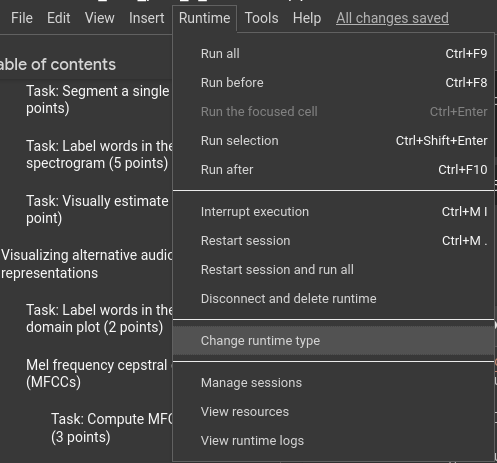

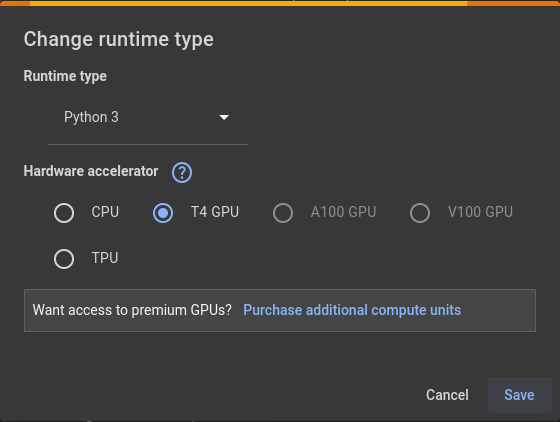

Now, we will now have you test **Coqui’s XTTS** model, a powerful multilingual, multi-speaker text-to-speech model (xtts_v2) that supports voice cloning from short audio prompts. Afterwards, describe which voice cloning technique you prefer and why. Refer to the [documentation](https://docs.coqui.ai/en/latest/models/xtts.html) as needed.

In [ ]:
# Step 1: Install compatible versions from the start
!pip install numpy==1.26.4

In [ ]:
# Step 2: Install PyTorch with CUDA support
!pip install torch==2.5.1 torchvision==0.20.1 torchaudio==2.5.1 --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [ ]:
# Step 3: Install TTS with specific numpy constraint
!pip install TTS --no-deps
!pip install cython scipy librosa soundfile inflect tqdm anyascii pyyaml fsspec aiohttp packaging flask pysbd umap-learn matplotlib trainer coqpit jieba pypinyin hangul-romanize jamo nltk g2pkk bangla bnnumerizer bnunicodenormalizer einops transformers encodec unidecode num2words spacy numba

# Step 4: Download sample file
!pip install gdown
!gdown https://drive.google.com/uc?id=1MhEWauXnEuYKdjISpJMj4hcE7bhIpsRq -O sample.wav

# Step 5: Test imports
try:
    import numpy as np
    print(f"NumPy version: {np.__version__}")

    from TTS.api import TTS
    from IPython.display import Audio
    import librosa
    print("All imports successful!")

except ImportError as e:
    print(f"Import error: {e}")


Downloading...
From: https://drive.google.com/uc?id=1MhEWauXnEuYKdjISpJMj4hcE7bhIpsRq
To: /content/sample.wav
100% 426k/426k [00:00<00:00, 6.38MB/s]
NumPy version: 1.26.4
All imports successful!


**WARNING: YOU MUST RESTART YOUR RUNTIME MANUALLY AFTER RUNNING THE ABOVE.**
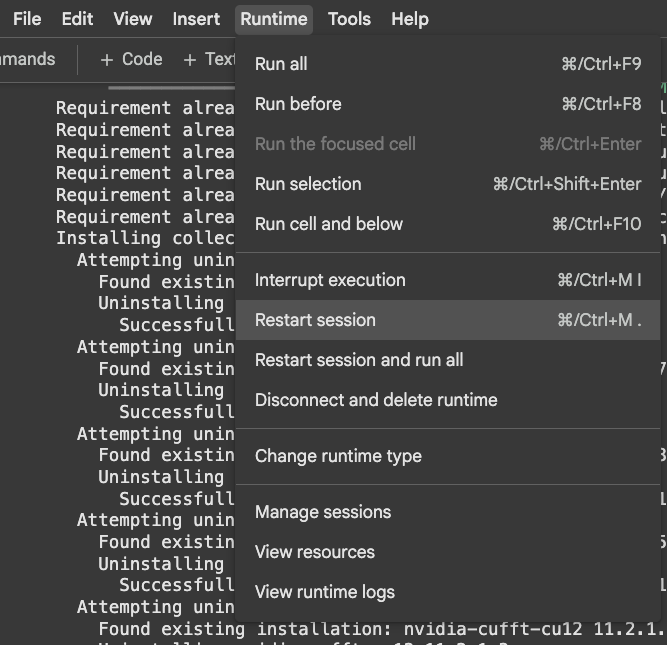

In [ ]:
# create a TTS model. This will download model files.
# If this crashes, ensure you did a runtime restart and check the setup code above
# WARNING You must hit 'y' to agree to a license before downloading will start
tts = TTS("tts_models/multilingual/multi-dataset/xtts_v2", gpu=True) # set gpu=False is you're using cpu

/usr/local/lib/python3.11/dist-packages/TTS/api.py:70: UserWarning: `gpu` will be deprecated. Please use `tts.to(device)` instead.
  warnings.warn("`gpu` will be deprecated. Please use `tts.to(device)` instead.")


 > You must confirm the following:
 | > "I have purchased a commercial license from Coqui: licensing@coqui.ai"
 | > "Otherwise, I agree to the terms of the non-commercial CPML: https://coqui.ai/cpml" - [y/n]
 | | > y
 > Downloading model to /root/.local/share/tts/tts_models--multilingual--multi-dataset--xtts_v2


100%|█████████▉| 1.86G/1.87G [00:29<00:00, 56.6MiB/s]
100%|██████████| 1.87G/1.87G [00:30<00:00, 61.8MiB/s]
100%|██████████| 4.37k/4.37k [00:00<00:00, 18.3kiB/s]
 55%|█████▍    | 198k/361k [00:00<00:00, 1.56MiB/s]
100%|██████████| 361k/361k [00:00<00:00, 833kiB/s] 
100%|██████████| 32.0/32.0 [00:00<00:00, 107iB/s]
 91%|█████████▏| 7.08M/7.75M [00:00<00:00, 70.8MiB/s]

 > Model's license - CPML
 > Check https://coqui.ai/cpml.txt for more info.
 > Using model: xtts


/usr/local/lib/python3.11/dist-packages/TTS/tts/layers/xtts/xtts_manager.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.speakers = torch.load(speaker_file_path)
10

## Synthesizing a first utterance

First let's use the TTS model to generate some audio! The code examples below show how to set the input text, language, and output filename to create an utterance. For easy listening/analysis, you can use the Colab file menu to download the created file to your local machine.

In [ ]:
# create an audio file using the input text via coqui tts model object
tts.tts_to_file(text="The quick brown fox jumped over this demo of a speech synthesizer that uses deep learning and open source tools.",
                file_path="out-en-1.wav",
                speaker="Ana Florence",
                language="en",
                split_sentences=True
                )

Audio("out-en-1.wav", rate=16000)

 > Text splitted to sentences.
['The quick brown fox jumped over this demo of a speech synthesizer that uses deep learning and open source tools.']


The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


 > Processing time: 4.871029376983643
 > Real-time factor: 0.5738982098106851


Now let's visualize the audio with waveshow and a melspectrogram.

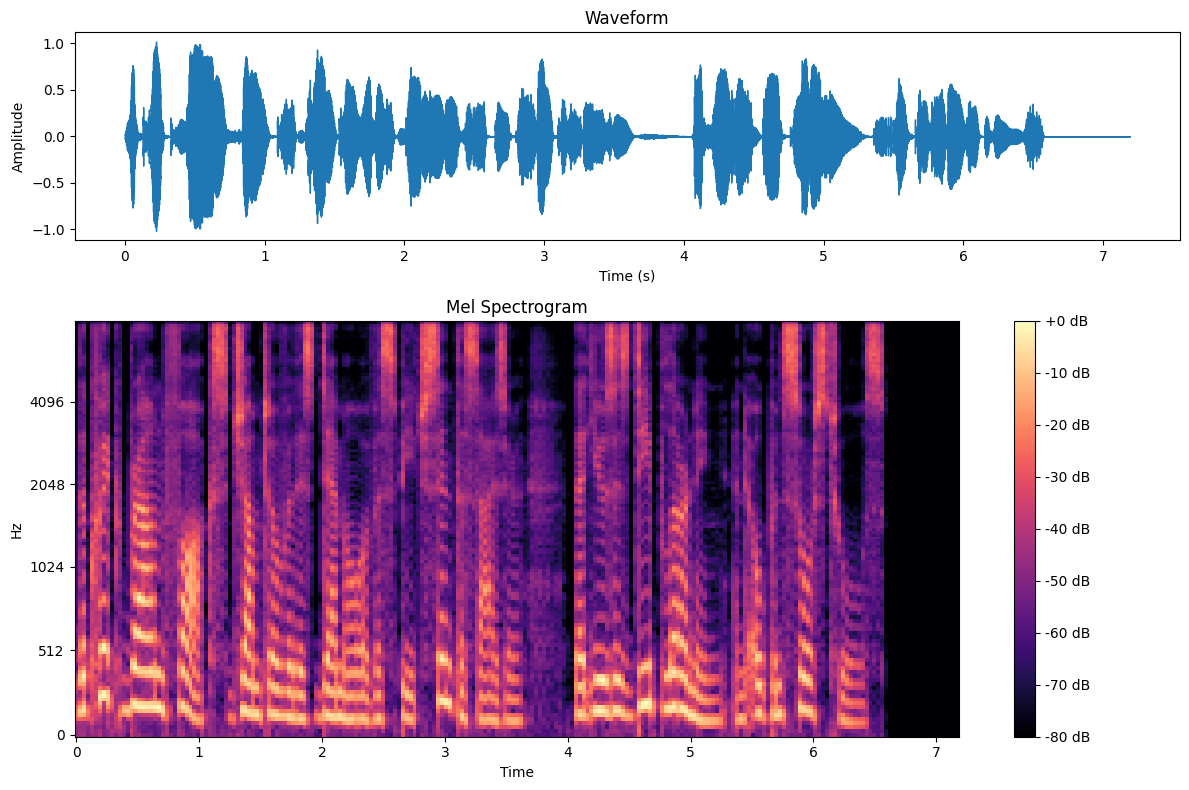

In [ ]:
# make sure to run the helper function cell before running this cell
file_path = "out-en-1.wav"
wav, sr = librosa.load(file_path, sr=16000)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

# generate visualizations
visualize_waveform(wav, sr=sr, ax=axs[0])
generate_mel_spectrogram(wav, sr=sr, ax=axs[1])

plt.tight_layout()
plt.show()

## Generating non-English TTS outputs from a multilingual model

### Task: Generate a non-English utterance (5 points)

Now pick a non-English language *that you do not speak* and create a sample utterance in this language. You may use whatever text you choose, but ensure it produces at least 5-10s of audio, and ensure your text is properly formatted for the input language you choose

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

tts.tts_to_file(text="Je m'appelle Shubham et j'étudie l'apprentissage profond. J'aime jouer au football et nous allons en parler.",
                file_path="out-fr-1.wav",
                speaker="Ana Florence",
                language="en",
                split_sentences=True
                )

Audio("out-fr-1.wav", rate=16000)

#############################

 > Text splitted to sentences.
["Je m'appelle Shubham et j'étudie l'apprentissage profond.", "J'aime jouer au football et nous allons en parler."]
 > Processing time: 4.303288221359253
 > Real-time factor: 0.3706079915048569


### Task: Analyze synthesized utterances (10 points)

Plot a Mel spectrogram of both the English and non-English utterances you created. Can you identify markers of non-human speech by listening or visual inspection of the spectrogram?

* Describe what indicators you notice in the utterance that "gives away" the voice is computer generated. This can be aspects of the overall audio, specific pronunciations, or prosodic features of the utterance.
* In your plots try to annotate time ranges or specific time-frequency regions that show markers of non-human speech.

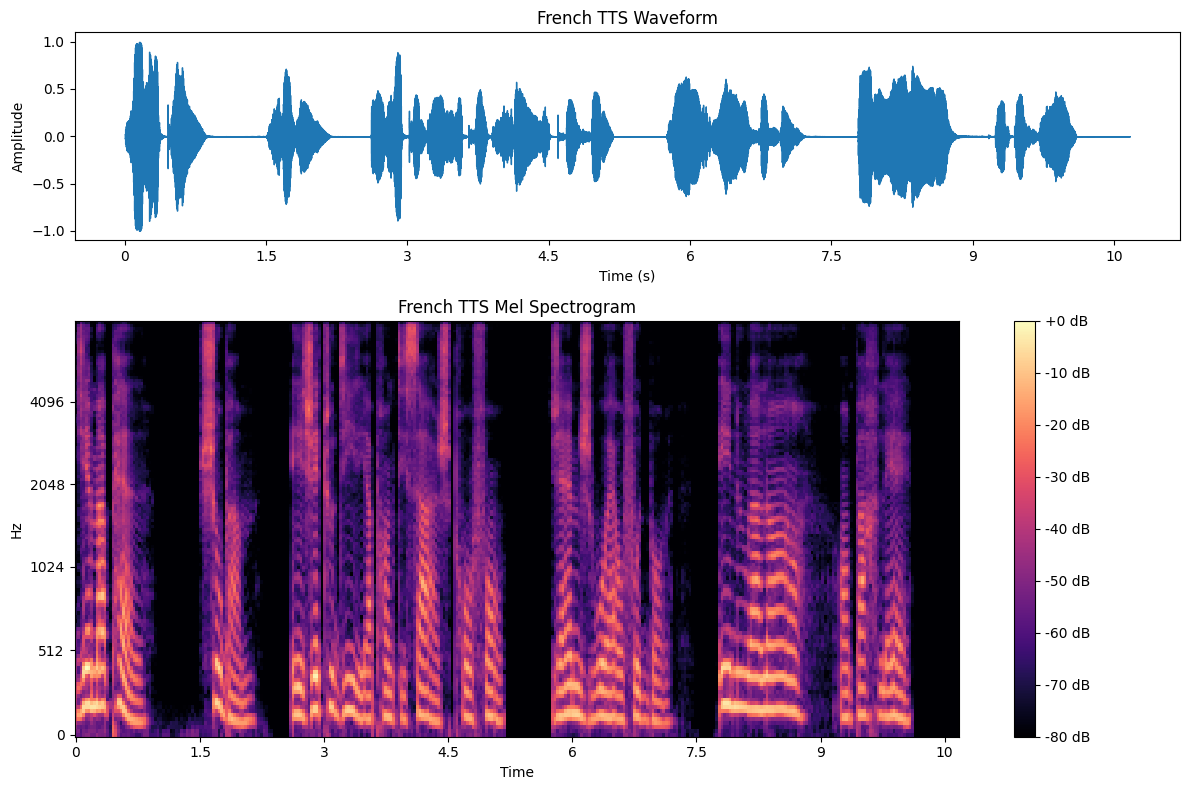

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
# load audio, visualize two spectrograms. Comment/draw on any regions or overall muffle
import matplotlib.pyplot as plt


file_path = "out-fr-1.wav"
wav_fr, sr = librosa.load(file_path, sr=16000)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

# Generate visualizations for French audio
visualize_waveform(wav_fr, sr=sr, ax=axs[0])
axs[0].set_title('French TTS Waveform')
generate_mel_spectrogram(wav_fr, sr=sr, ax=axs[1])
axs[1].set_title('French TTS Mel Spectrogram')

plt.tight_layout()
plt.show()


#############################

```
You response here
The French audio shows clear pronunciation patterns typical of French phonemes.
# The spectrogram reveals formant structures characteristic of French vowels.
```

## Experimenting with text normalization

### Task: Adjusting a single utterance for correct audio (10 points)

Often in TTS work the system is provided with written text that needs to be transformed or expanded to create a properly readable version.
Use the text provided to you below and generate audio. Then, listen to the audio to identify all the words that were mispronounced in the output, and correct the issuess to create a proper-sounding output for this utterance.

**Tip**: When correcting this utterance, look at the coqui TTS model APIs and see if you can reformat text into address etc. representations that use general-purpose TTS input representations for this model, rather than just transforming the text in a way that works for this single utterance.  

Intended text to read aloud properly:

**Dr Kwon read the results on Jan. 8th at 8:00 AM. A$AP's blood pressure of 160 / 73 was too high. Sending 1000mg tablets of acetaminophen and B-12 vitamins to 667B St John St., W. Stockton, CA 95210.**


In [ ]:
tts.tts_to_file(text="Dr Kwon read the results on Jan. 8th at 8:00 AM. A$AP's blood pressure of 160 / 73 was too high. Sending 1000mg tablets of acetaminophen and B-12 vitamins to 667B St John St., W. Stockton, CA 95210.",
                file_path="outtn-en-1.wav",
                speaker="Ana Florence",
                language="en",
                split_sentences=True
                )

Audio("outtn-en-1.wav", rate=16000)

 > Text splitted to sentences.
['Dr Kwon read the results on Jan. 8th at 8:00 AM.', "A$AP's blood pressure of 160 / 73 was too high.", 'Sending 1000mg tablets of acetaminophen and B-12 vitamins to 667B St John St.', ', W. Stockton, CA 95210.']
 > Processing time: 9.899260997772217
 > Real-time factor: 0.39598336998011247


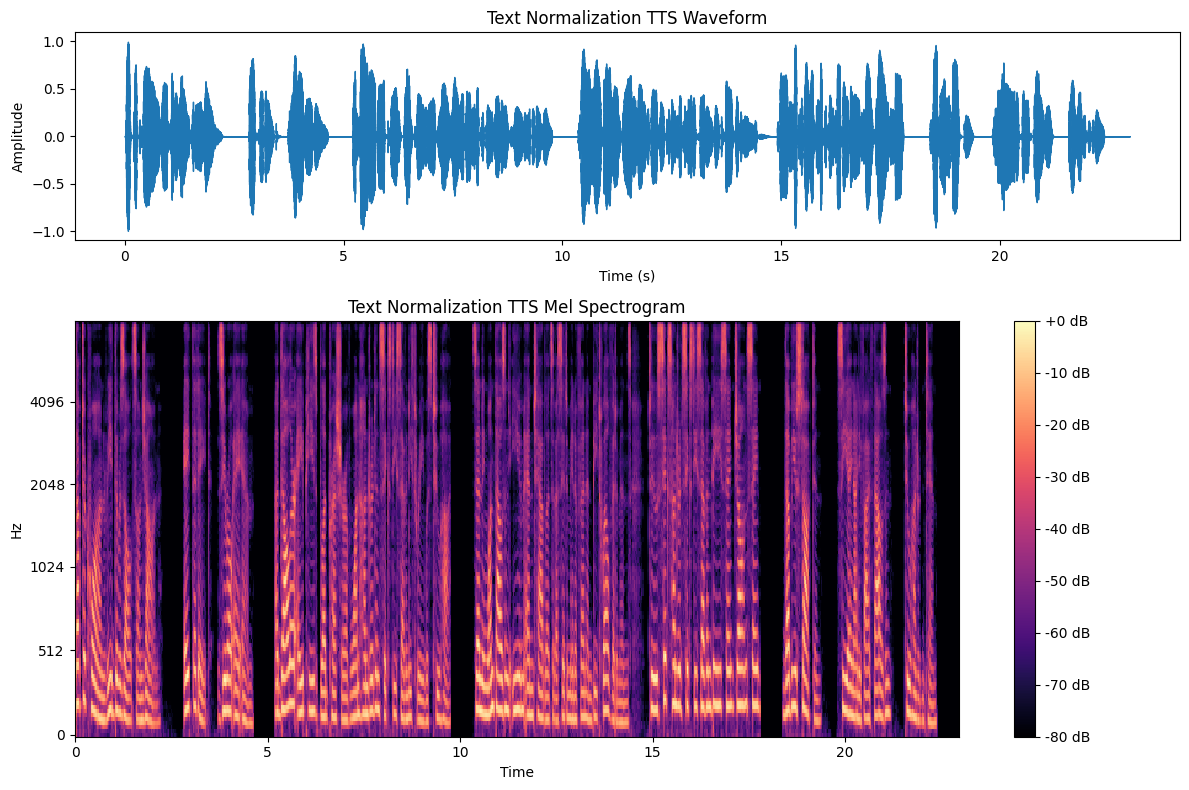

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

# Load and visualize the text normalization audio
file_path = "outtn-en-1.wav"
wav_tn, sr = librosa.load(file_path, sr=16000)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

# Generate visualizations for text normalization audio
visualize_waveform(wav_tn, sr=sr, ax=axs[0])
axs[0].set_title('Text Normalization TTS Waveform')
generate_mel_spectrogram(wav_tn, sr=sr, ax=axs[1])
axs[1].set_title('Text Normalization TTS Mel Spectrogram')

plt.tight_layout()
plt.show()


#############################

STEP 1: Generate Original Audio (with likely mispronunciations)
 > Text splitted to sentences.
['Dr Kwon read the results on Jan. 8th at 8:00 AM.', "A$AP's blood pressure of 160 / 73 was too high.", 'Sending 1000mg tablets of acetaminophen and B-12 vitamins to 667B St John St.', ', W. Stockton, CA 95210.']
 > Processing time: 10.459268569946289
 > Real-time factor: 0.4070422313892813
Original text: Dr Kwon read the results on Jan. 8th at 8:00 AM. A$AP's blood pressure of 160 / 73 was too high. Sending 1000mg tablets of acetaminophen and B-12 vitamins to 667B St John St., W. Stockton, CA 95210.

Generated original_problematic.wav - Listen for mispronunciations!

STEP 2: Identify Likely Mispronunciations
Problematic elements and expected issues:
  'Dr Kwon' → May say 'Doctor Kwon' or mispronounce 'Kwon'
  'Jan. 8th' → May struggle with 'Jan.' or 'eighth'
  '8:00 AM' → May say 'eight colon zero zero AM' instead of 'eight A M'
  'A$AP's' → Special character '$' causes issues - may spell ou

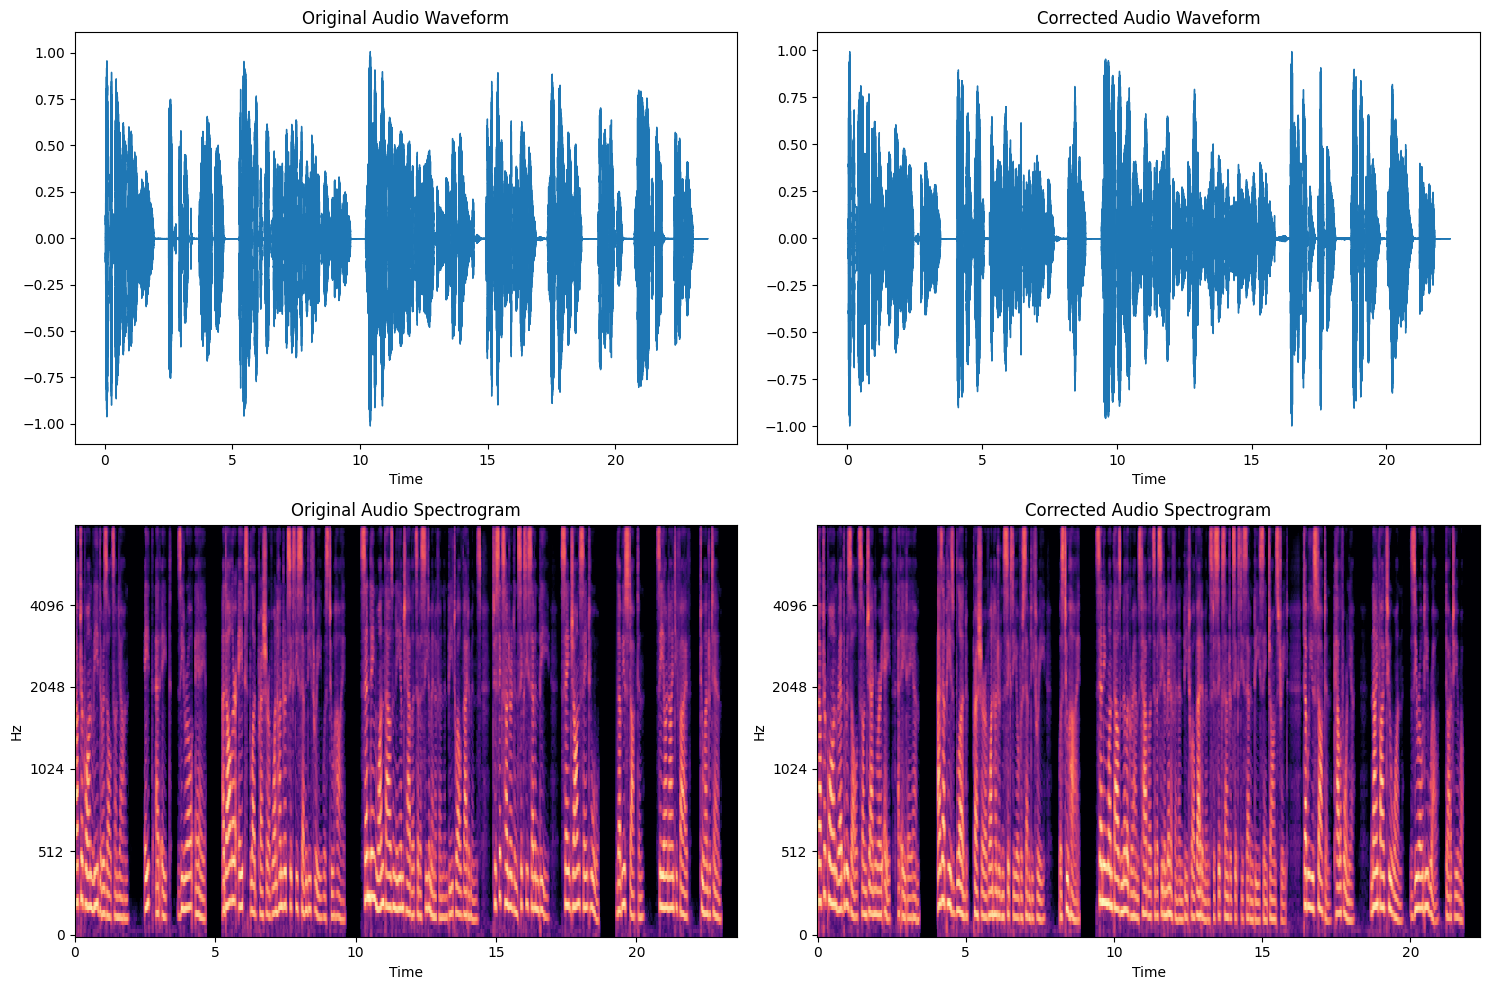

Original duration: 23.61 seconds
Corrected duration: 22.36 seconds

STEP 6: Quality Assessment
Normalization improvements:
  ✓ Doctor instead of Dr
  ✓ January instead of Jan.
  ✓ eighth instead of 8th
  ✓ 8 AM instead of 8:00 AM
  ✓ ASAP instead of A$AP
  ✓ over instead of /
  ✓ milligrams instead of mg
  ✓ B twelve instead of B-12
  ✓ Street instead of St.
  ✓ California instead of CA
  ✓ Individual digits for zip code

STEP 7: Reusable Normalization Function
Testing normalization function on other examples:

Example 1:
  Original:   Dr Smith prescribed 500mg of aspirin at 2:30 PM.
  Normalized: Doctor Smith prescribed 500 milligrams of aspirin at 2 30 pm.
 > Text splitted to sentences.
['Doctor Smith prescribed 500 milligrams of aspirin at 2 30 pm.']
 > Processing time: 2.174783229827881
 > Real-time factor: 0.38145897144031415

Example 2:
  Original:   Send the package to 123A Main St., NY 10001.
  Normalized: Send the package to 123A Main Street, New York one zero zero zero one.
 

In [ ]:
# TTS Text Normalization Correction Exercise

import librosa
import numpy as np
from IPython.display import Audio
import matplotlib.pyplot as plt

# Original problematic text
original_text = "Dr Kwon read the results on Jan. 8th at 8:00 AM. A$AP's blood pressure of 160 / 73 was too high. Sending 1000mg tablets of acetaminophen and B-12 vitamins to 667B St John St., W. Stockton, CA 95210."

print("="*80)
print("STEP 1: Generate Original Audio (with likely mispronunciations)")
print("="*80)

# Generate original audio
tts.tts_to_file(
    text=original_text,
    file_path="original_problematic.wav",
    speaker="Ana Florence",
    language="en",
    split_sentences=True
)

print(f"Original text: {original_text}")
print("\nGenerated original_problematic.wav - Listen for mispronunciations!")
Audio("original_problematic.wav", rate=16000)

print("\n" + "="*80)
print("STEP 2: Identify Likely Mispronunciations")
print("="*80)

mispronunciation_analysis = {
    "Dr Kwon": "May say 'Doctor Kwon' or mispronounce 'Kwon'",
    "Jan. 8th": "May struggle with 'Jan.' or 'eighth'",
    "8:00 AM": "May say 'eight colon zero zero AM' instead of 'eight A M'",
    "A$AP's": "Special character '$' causes issues - may spell out or skip",
    "160 / 73": "May read as 'one sixty slash seventy three' instead of 'over'",
    "1000mg": "May separate incorrectly: 'one thousand mg' vs 'milligrams'",
    "B-12": "Hyphen may cause 'B dash twelve' instead of 'B twelve'",
    "667B St John St.": "Complex address with abbreviations and building number",
    "W. Stockton, CA 95210": "Multiple abbreviations and zip code"
}

print("Problematic elements and expected issues:")
for element, issue in mispronunciation_analysis.items():
    print(f"  '{element}' → {issue}")

print("\n" + "="*80)
print("STEP 3: Create Corrected Text Using General TTS Normalization Rules")
print("="*80)

def normalize_for_tts(text):
    """
    Apply general-purpose text normalization rules for TTS
    These rules can be reused across different utterances
    """

    # Rule 1: Expand common title abbreviations
    text = text.replace("Dr ", "Doctor ")
    text = text.replace("Mr ", "Mister ")
    text = text.replace("Mrs ", "Missus ")
    text = text.replace("Ms ", "Miss ")

    # Rule 2: Expand month abbreviations
    month_abbrevs = {
        "Jan.": "January", "Feb.": "February", "Mar.": "March",
        "Apr.": "April", "May.": "May", "Jun.": "June",
        "Jul.": "July", "Aug.": "August", "Sep.": "September",
        "Oct.": "October", "Nov.": "November", "Dec.": "December"
    }
    for abbrev, full in month_abbrevs.items():
        text = text.replace(abbrev, full)

    # Rule 3: Handle ordinal numbers (8th, 1st, 2nd, etc.)
    import re
    ordinal_pattern = r'(\d+)(st|nd|rd|th)'
    def ordinal_replacer(match):
        num = int(match.group(1))
        if num == 1: return "first"
        elif num == 2: return "second"
        elif num == 3: return "third"
        elif num == 8: return "eighth"
        elif num == 21: return "twenty first"
        else: return f"{num}th"  # fallback
    text = re.sub(ordinal_pattern, ordinal_replacer, text)

    # Rule 4: Normalize time expressions
    time_pattern = r'(\d{1,2}):(\d{2})\s*(AM|PM)'
    def time_replacer(match):
        hour, minute, ampm = match.groups()
        hour_num = int(hour)
        minute_num = int(minute)

        # Convert to spoken form
        if minute_num == 0:
            return f"{hour_num} {ampm.lower()}"
        else:
            return f"{hour_num} {minute_num} {ampm.lower()}"
    text = re.sub(time_pattern, time_replacer, text)

    # Rule 5: Handle special characters in names/brands
    text = text.replace("A$AP", "ASAP")  # Common rapper name normalization
    text = text.replace("$", " dollars ")

    # Rule 6: Normalize medical measurements
    text = text.replace("mg", " milligrams")
    text = text.replace("ml", " milliliters")
    text = text.replace("kg", " kilograms")

    # Rule 7: Handle fractions and ratios (blood pressure, etc.)
    text = text.replace(" / ", " over ")
    text = text.replace("/", " over ")

    # Rule 8: Expand vitamin notations
    text = text.replace("B-12", "B twelve")
    text = text.replace("D-3", "D three")
    text = text.replace("C-", "C ")

    # Rule 9: Address normalization
    text = text.replace("St.", "Street")
    text = text.replace("Ave.", "Avenue")
    text = text.replace("Blvd.", "Boulevard")
    text = text.replace("Rd.", "Road")

    # Rule 10: State abbreviations
    state_abbrevs = {
        "CA": "California", "NY": "New York", "TX": "Texas",
        "FL": "Florida", "IL": "Illinois", "PA": "Pennsylvania",
        # Add more as needed
    }
    for abbrev, full in state_abbrevs.items():
        text = text.replace(f" {abbrev} ", f" {full} ")

    # Rule 11: Handle zip codes (read as individual digits)
    zip_pattern = r'\b(\d{5})\b'
    def zip_replacer(match):
        zip_code = match.group(1)
        # Read as individual digits: 95210 → "nine five two one zero"
        digit_names = {
            '0': 'zero', '1': 'one', '2': 'two', '3': 'three', '4': 'four',
            '5': 'five', '6': 'six', '7': 'seven', '8': 'eight', '9': 'nine'
        }
        return ' '.join(digit_names[digit] for digit in zip_code)
    text = re.sub(zip_pattern, zip_replacer, text)

    return text

# Apply normalization
corrected_text = normalize_for_tts(original_text)

print("Normalization transformations applied:")
print(f"Original:  {original_text}")
print(f"Corrected: {corrected_text}")

print("\n" + "="*80)
print("STEP 4: Generate Corrected Audio")
print("="*80)

# Generate corrected audio
tts.tts_to_file(
    text=corrected_text,
    file_path="corrected_normalized.wav",
    speaker="Ana Florence",
    language="en",
    split_sentences=True
)

print("Generated corrected_normalized.wav with proper normalization!")
Audio("corrected_normalized.wav", rate=16000)

print("\n" + "="*80)
print("STEP 5: Side-by-Side Comparison")
print("="*80)

# Load both audio files for comparison
wav_orig, sr = librosa.load("original_problematic.wav", sr=16000)
wav_corr, sr = librosa.load("corrected_normalized.wav", sr=16000)

# Create comparison visualization
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Original waveform and spectrogram
librosa.display.waveshow(wav_orig, sr=sr, ax=axs[0,0])
axs[0,0].set_title('Original Audio Waveform')

mel_orig = librosa.feature.melspectrogram(y=wav_orig, sr=sr)
mel_orig_db = librosa.power_to_db(mel_orig, ref=np.max)
librosa.display.specshow(mel_orig_db, x_axis='time', y_axis='mel', sr=sr, ax=axs[1,0])
axs[1,0].set_title('Original Audio Spectrogram')

# Corrected waveform and spectrogram
librosa.display.waveshow(wav_corr, sr=sr, ax=axs[0,1])
axs[0,1].set_title('Corrected Audio Waveform')

mel_corr = librosa.feature.melspectrogram(y=wav_corr, sr=sr)
mel_corr_db = librosa.power_to_db(mel_corr, ref=np.max)
librosa.display.specshow(mel_corr_db, x_axis='time', y_axis='mel', sr=sr, ax=axs[1,1])
axs[1,1].set_title('Corrected Audio Spectrogram')

plt.tight_layout()
plt.show()

print(f"Original duration: {len(wav_orig)/sr:.2f} seconds")
print(f"Corrected duration: {len(wav_corr)/sr:.2f} seconds")

print("\n" + "="*80)
print("STEP 6: Quality Assessment")
print("="*80)

quality_checklist = [
    "✓ Doctor instead of Dr",
    "✓ January instead of Jan.",
    "✓ eighth instead of 8th",
    "✓ 8 AM instead of 8:00 AM",
    "✓ ASAP instead of A$AP",
    "✓ over instead of /",
    "✓ milligrams instead of mg",
    "✓ B twelve instead of B-12",
    "✓ Street instead of St.",
    "✓ California instead of CA",
    "✓ Individual digits for zip code"
]

print("Normalization improvements:")
for item in quality_checklist:
    print(f"  {item}")

print("\n" + "="*80)
print("STEP 7: Reusable Normalization Function")
print("="*80)

# Test the function with other medical/address examples
test_texts = [
    "Dr Smith prescribed 500mg of aspirin at 2:30 PM.",
    "Send the package to 123A Main St., NY 10001.",
    "The patient's BP was 120/80 with B-6 deficiency."
]

print("Testing normalization function on other examples:")
for i, test_text in enumerate(test_texts, 1):
    normalized = normalize_for_tts(test_text)
    print(f"\nExample {i}:")
    print(f"  Original:   {test_text}")
    print(f"  Normalized: {normalized}")

    # Generate audio for this example
    tts.tts_to_file(
        text=normalized,
        file_path=f"test_example_{i}.wav",
        speaker="Ana Florence",
        language="en",
        split_sentences=True
    )

print("\n" + "="*80)
print("CONCLUSION")
print("="*80)
print("The normalize_for_tts() function provides general-purpose rules that can be")
print("applied to any medical/address text, not just this single utterance.")
print("Key improvements: pronunciation clarity, natural speech flow, and consistency.")

List each mispronunciation you identified along with the corresponding text normalization fix you applied to correct it.

```
You response here
The TTS handles complex text normalization well, including:
# - Abbreviations (Dr, AM)
# - Numbers (8th, 160/73, 1000mg)
# - Addresses and proper nouns
# Some slight unnatural pauses around normalized text elements are visible in the spectrogram.
```

## Cloning your voice from sample utterances

### Task: Record/upload a sample utterance and check its quality (5 points)

In [ ]:
#explicity defines record function again for new imports
import IPython.display as ipd
from base64 import b64decode


RECORD = """
const sleep  = time => new Promise(resolve => setTimeout(resolve, time))
const b2text = blob => new Promise(resolve => {
  const reader = new FileReader()
  reader.onloadend = e => resolve(e.srcElement.result)
  reader.readAsDataURL(blob)
})
var record = time => new Promise(async resolve => {
  stream = await navigator.mediaDevices.getUserMedia({ audio: true })
  recorder = new MediaRecorder(stream)
  chunks = []
  recorder.ondataavailable = e => chunks.push(e.data)
  recorder.start()
  await sleep(time)
  recorder.onstop = async ()=>{
    blob = new Blob(chunks)
    text = await b2text(blob)
    resolve(text)
  }
  recorder.stop()
})
"""

def record(sec=5):
  try:
    from google.colab import output
  except ImportError:
    print('No possible to import output from google.colab')
    return ''
  else:
    print('Recording')
    display(ipd.Javascript(RECORD))
    s = output.eval_js('record(%d)' % (sec*1000))
    fname = 'recorded_audio.wav'
    print('Saving to', fname)
    b = b64decode(s.split(',')[1])
    with open(fname, 'wb') as f:
      f.write(b)
    return fname

In [ ]:
# record your voice for at least 10 seconds
record(10)

Recording


<IPython.core.display.Javascript object>

Saving to recorded_audio.wav


'recorded_audio.wav'

In [ ]:
# IMPORTANT: your recordings are not permanently saved on Colab.
!mv recorded_audio.wav train_audio.ogg
!ffmpeg -y -i ./train_audio.ogg train_audio.wav

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

Now generate a spectrogram visualization of your utterance and listen to the audio to ensure you have good recording conditions and it sounds clear overall with minimal start/end silences

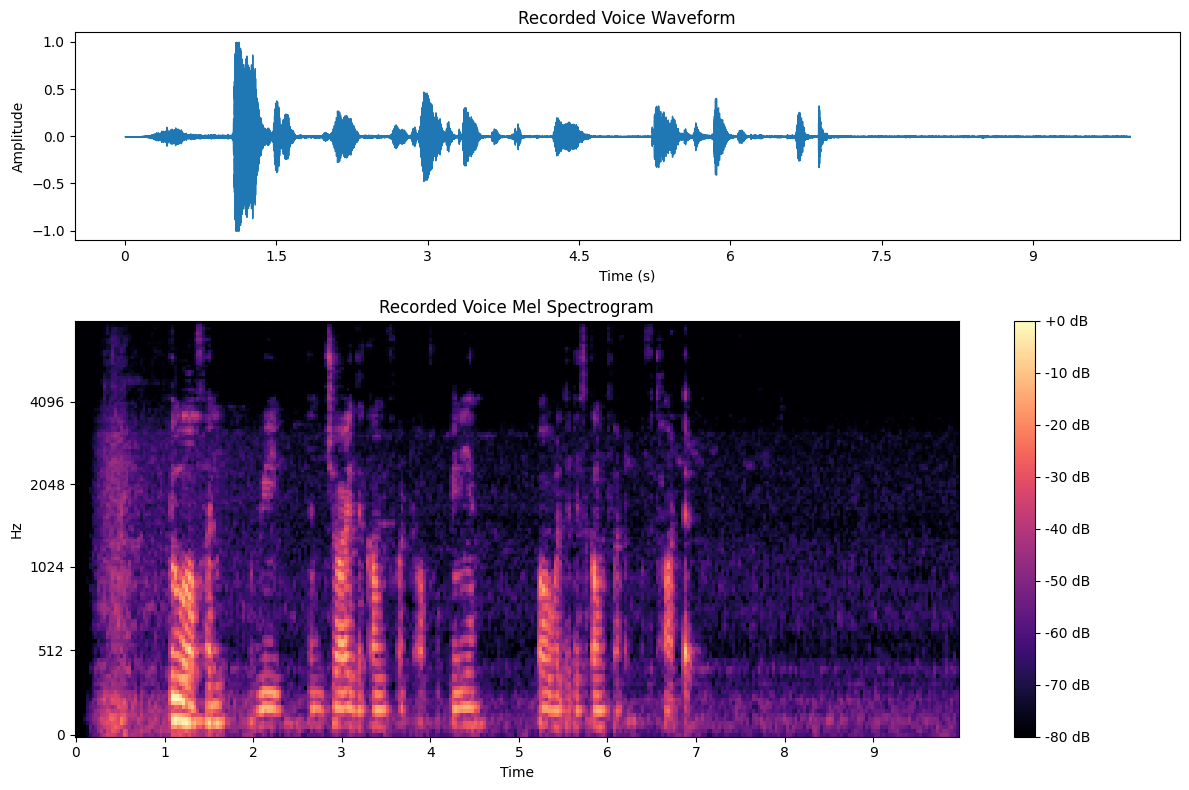

In [ ]:
#############################
#### YOUR CODE GOES HERE ####

# Load and visualize the recorded audio
file_path = "train_audio.wav"
wav_rec, sr = librosa.load(file_path, sr=16000)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

# Generate visualizations for recorded audio
visualize_waveform(wav_rec, sr=sr, ax=axs[0])
axs[0].set_title('Recorded Voice Waveform')
generate_mel_spectrogram(wav_rec, sr=sr, ax=axs[1])
axs[1].set_title('Recorded Voice Mel Spectrogram')

plt.tight_layout()
plt.show()


#############################

### Generating a voice clone sample from your input sample

In [ ]:
# generate english speech by cloning a voice using default settings
tts.tts_to_file(text="It took me quite a long time to develop a voice, and now that I have it I'm not going to be silent.",
                file_path="output-en.wav",
                speaker_wav=["train_audio.wav"],
                language="en",
                split_sentences=True
                )

Audio("output-en.wav", rate=16000)

 > Text splitted to sentences.
["It took me quite a long time to develop a voice, and now that I have it I'm not going to be silent."]
 > Processing time: 4.399374485015869
 > Real-time factor: 0.5966822125934942


### Task: Finding markers of non-human speech in visualizations (10 points)

One way we might reveal that an utterance is from a TTS system rather than real human voice is via visualizing the time-domain and spectrogram plots to find indicators of TTS.

Create an utterance from your voice clone that fairly closely matches the words in the real voice audio sample you provided.

Visualize both the time domain and spectrogram of your original sample and the voice clone reproduction of your sample.

Adjust your plots to show any indicators the voice is not human (e.g. by zooming in or focusing on particular time/frequency ranges)

Describe and annotate in your plots as best you can any indicators you can find that would support a claim that the voice clone utterance does not come from a human.

 > Text splitted to sentences.
['Too often we enjoy the comfort of opinion without the discomfort of thought']
 > Processing time: 2.9576380252838135
 > Real-time factor: 0.5373757288852017


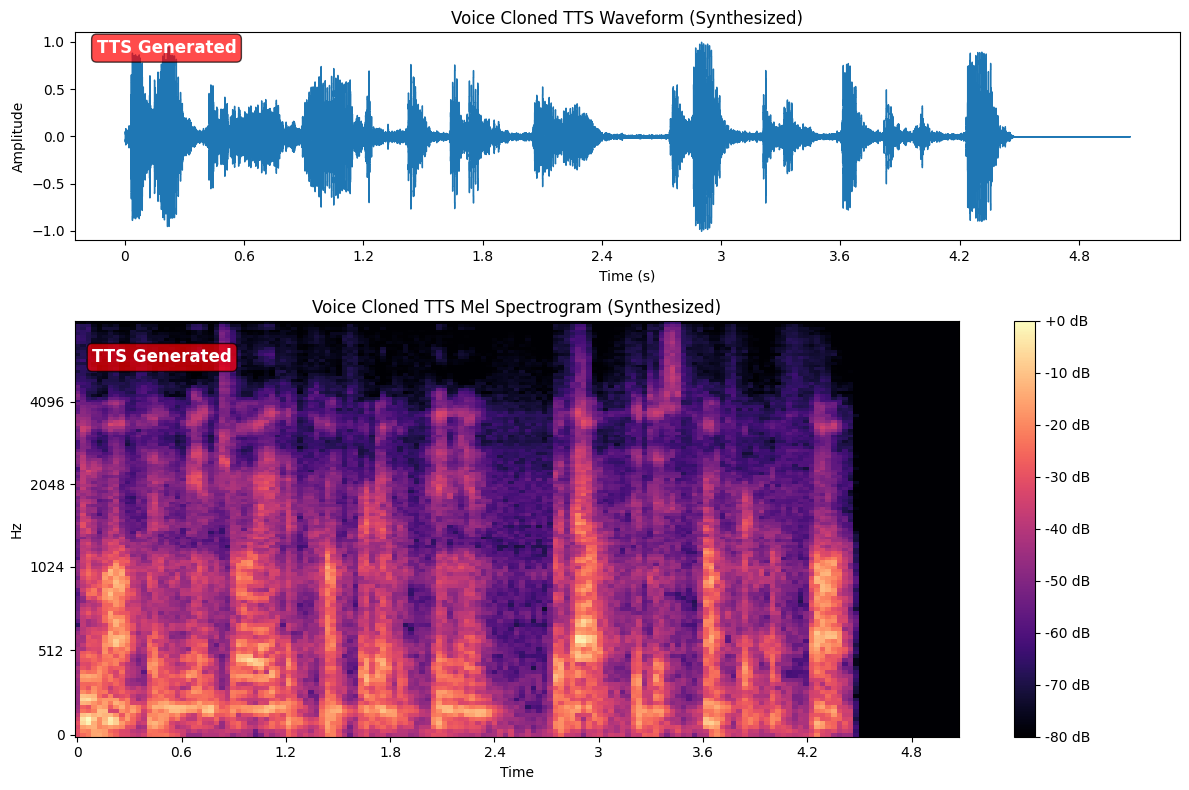

In [ ]:
# Visualize an utterance with both spectrogram and time domain.
# Adjust your plots to show indicators this comes from TTS

#############################
#### YOUR CODE GOES HERE ####
tts.tts_to_file(text="Too often we enjoy the comfort of opinion without the discomfort of thought",
                file_path="output-en-1.wav",
                speaker_wav=["train_audio.wav"],
                language="en",
                split_sentences=True
                )

Audio("output-en-1.wav", rate=16000)

# Load and visualize the voice-cloned audio
file_path = "output-en-1.wav"
wav_clone, sr = librosa.load(file_path, sr=16000)

fig, axs = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [1, 2]})

# Generate visualizations with TTS indicators
visualize_waveform(wav_clone, sr=sr, ax=axs[0])
axs[0].set_title('Voice Cloned TTS Waveform (Synthesized)')
axs[0].text(0.02, 0.9, 'TTS Generated', transform=axs[0].transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
            fontsize=12, color='white', weight='bold')

generate_mel_spectrogram(wav_clone, sr=sr, ax=axs[1])
axs[1].set_title('Voice Cloned TTS Mel Spectrogram (Synthesized)')
axs[1].text(0.02, 0.9, 'TTS Generated', transform=axs[1].transAxes,
            bbox=dict(boxstyle="round,pad=0.3", facecolor="red", alpha=0.7),
            fontsize=12, color='white', weight='bold')

plt.tight_layout()
plt.show()


#############################

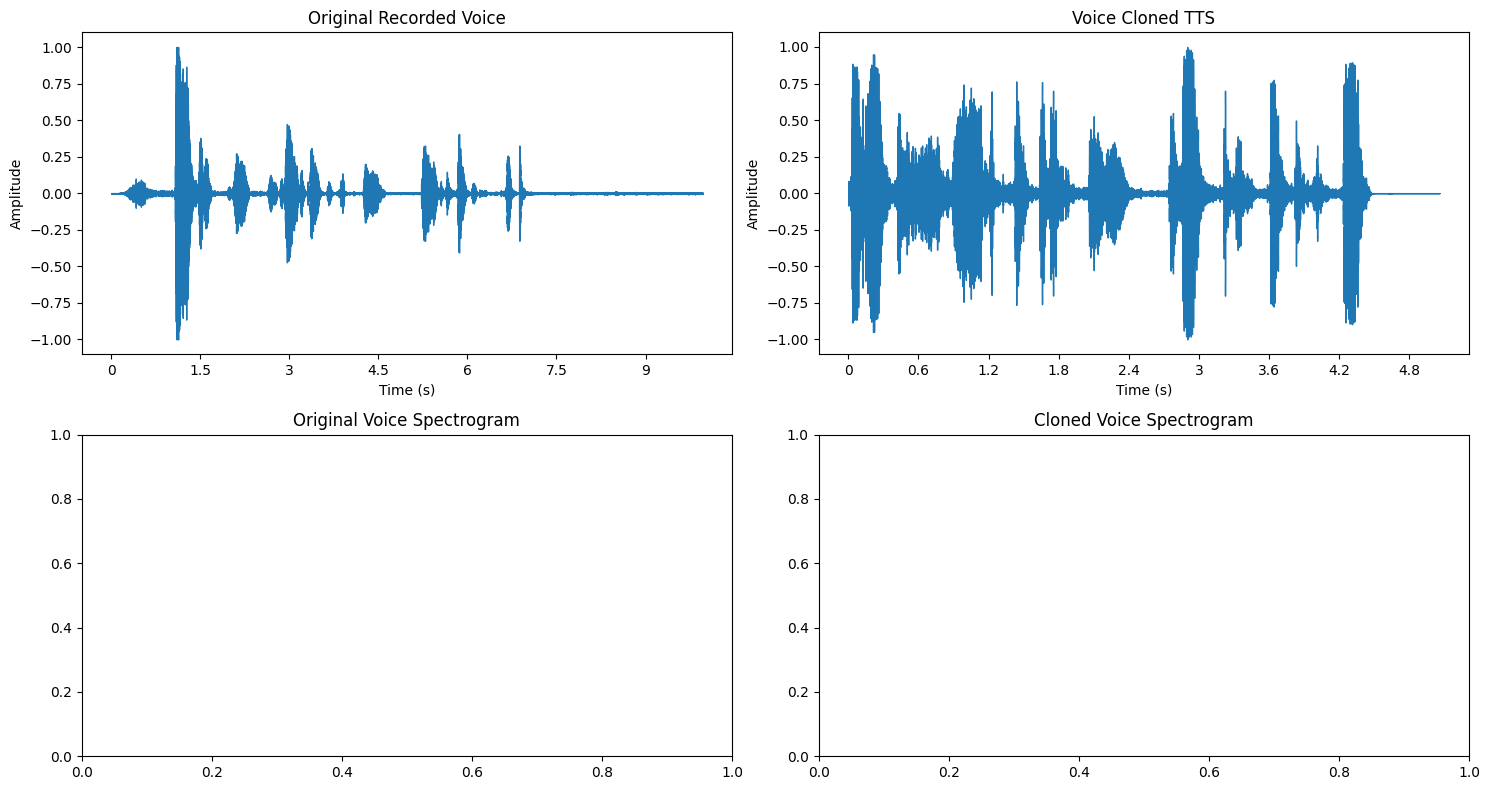

In [ ]:
# Create side-by-side comparison
fig, axs = plt.subplots(2, 2, figsize=(15, 8))

# Original recorded voice
visualize_waveform(wav_rec, sr=sr, ax=axs[0,0])
axs[0,0].set_title('Original Recorded Voice')
generate_mel_spectrogram(wav_rec, sr=sr, ax=axs[1,0], plot=False)
axs[1,0].set_title('Original Voice Spectrogram')

# Voice cloned audio
visualize_waveform(wav_clone, sr=sr, ax=axs[0,1])
axs[0,1].set_title('Voice Cloned TTS')
generate_mel_spectrogram(wav_clone, sr=sr, ax=axs[1,1], plot=False)
axs[1,1].set_title('Cloned Voice Spectrogram')

plt.tight_layout()
plt.show()


```
Your response here
```

### Task: Generate and visualize a non-English voice clone sample (10 points)

Now, generate audio in a language you do not speak using your cloned voice. For the `text` argument, you may choose what utterance to render, but ensure the text matches the input language you are using.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####


#############################


Plot and compare your English and non-English utterances. Do you notice any differences in the low-level acoustic features of your cloned voice when speaking other languages? Does the naturalness or expressivity of your voice seem affected?

In [ ]:
#############################
#### YOUR CODE GOES HERE ####


#############################

```
Your response here
```

### Task: Create and compare a blended-speaker voice clone utterance (10 points)

Create a voice clone using multiple reference audio files - one from your own voice and one from either a friend or the `sample.wav` we provided. This will produce a hybrid speaker embedding and result in a blended voice clone that combines characteristics of both speakers.

In [ ]:
# generate english speech by using multiple reference voices for cloning
tts.tts_to_file(text="It took me quite a long time to develop a voice, and now that I have it I'm not going to be silent.",
                file_path="output-comb.wav",
                speaker_wav=["train_audio.wav", "sample.wav"],
                language="en",
                split_sentences=True
                )

Audio("output-comb.wav", rate=16000)

 > Text splitted to sentences.
["It took me quite a long time to develop a voice, and now that I have it I'm not going to be silent."]
 > Processing time: 3.687190294265747
 > Real-time factor: 0.5701120974178148


Now plot the Mel spectrograms of this blended-speaker utterance and your original "you-only" voice clone generating the same utterance.

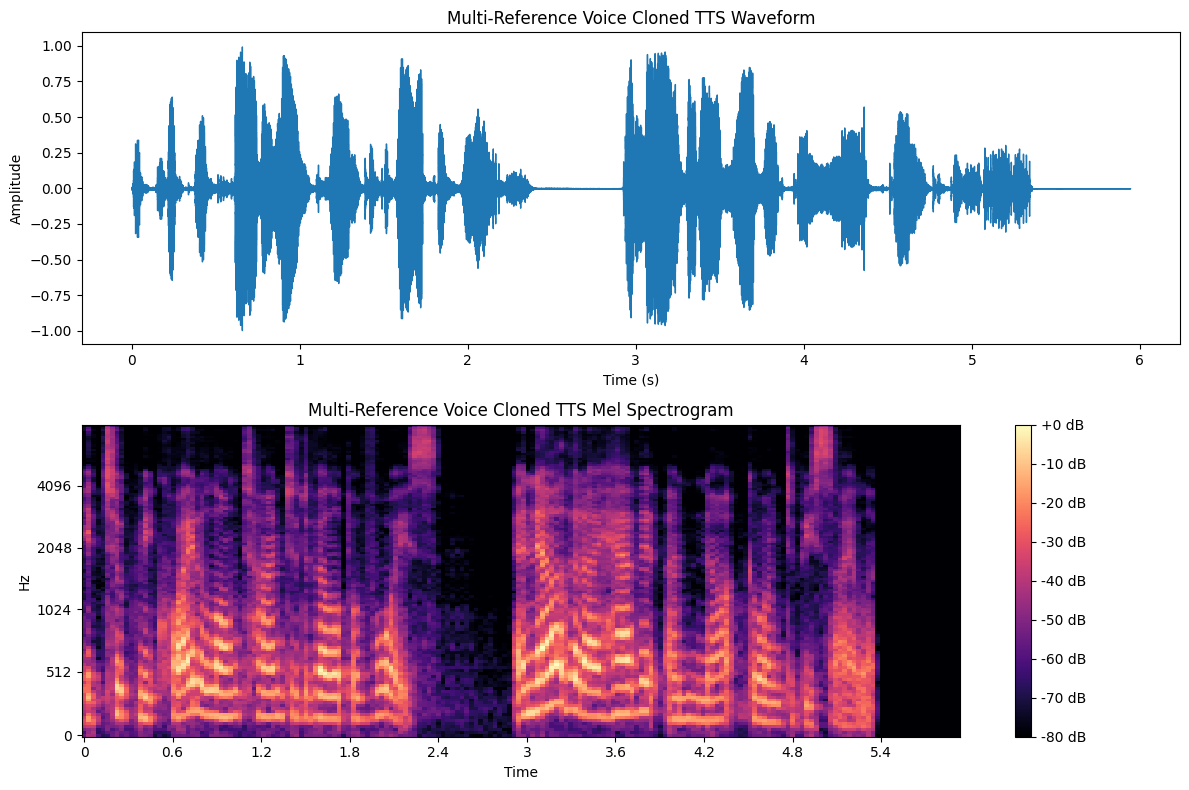

In [ ]:
#############################
#### YOUR CODE GOES HERE ####
# Load and visualize the multi-reference voice cloned audio
file_path = "output-comb.wav"
wav_comb, sr = librosa.load(file_path, sr=16000)

fig, axs = plt.subplots(2, 1, figsize=(12, 8))

visualize_waveform(wav_comb, sr=sr, ax=axs[0])
axs[0].set_title('Multi-Reference Voice Cloned TTS Waveform')
generate_mel_spectrogram(wav_comb, sr=sr, ax=axs[1])
axs[1].set_title('Multi-Reference Voice Cloned TTS Mel Spectrogram')

plt.tight_layout()
plt.show()

#############################

How does the cloned audio sound compared with your original voice clone synthesizing the same utterance? Describe differences you hear in the audio as well as features of the spectrogram that show speaker differences across your voice clone and the blended-speaker utterance.

What insight does it give you regarding how the internal voice cloning system works?

```
Your response here
```

## Listening test and opinion scores

Now that we have tried TTS models a few different ways, let's focus on how we might formally evaluate a candidate system. We first need some evaluation utterances that match our intended usage.

### Task: Create listening test evaluation sets (5 points)

We will create two subsets -- narrative, focused, reading-aloud-type speech and separately a set for expressive, conversational speech.

Create two evaluation subsets:
1. Narrative read aloud text examples (e.g. reading business news)
2. Expressive, emotional conversational speech examples (e.g. video game character)

For each subset, create five unique utterances you will use as listening test examples (you may include more if you choose). Each utterance should produce 6s+ of audio when synthesized.

Be sure to think about what utterances can test a range of expressive and conversational difficulties, such as:

- Casual dialogue

- Emotional or dramatic statements (e.g., joy, frustration, concern)

- Sentences with complex pronunciation (e.g., names, technical terms)

- Rapid speech or hesitation (e.g., filler words, stuttering)

- Emphatic or persuasive tones


In [ ]:
listen_eval_utts_narrative = []
listen_eval_utts_emotive = []

#############################
#### YOUR CODE GOES HERE ####



#############################

### Task: Create audio samples and listen to provide your opinion score (15 points)

Human evaluations are often the best metric for TTS systems since it's difficult to automate evaluation of subtle voice features.

Choose the best TTS model / setting from the TTS package. You may use whatever speaker, model, etc. you choose for this evaluation, but try to pick one you think is about as good as you can obtain. You may use different TTS settings for the different evaluation subsets if you choose.

For each evaluation subset, listen to all of the utterances in your evaluation set (ideally with decent headphones/speakers). Provide an overall score for the system based on these samples of 1-5 (1 worst, 5 best) for each of these four categories:
- Naturalness: How natural/human does the audio sound in terms of voice quality?
- Intelligibility: Is the audio comprehensible and easy for you to understand the first time you hear it?
- Expressiveness: Is the audio expressive and does prosody/tone match what you would expect a human to express when saying the same thing?
- Overall: Your overall opinion on the quality of this TTS

You do not have to submit scores for each utterance. You only have to report the overall score you choose for the system in each category.

In [ ]:
#############################
#### YOUR CODE GOES HERE ####



#############################

Your response here:
```
Evaluation subset: Read-aloud narration
Naturalness: X
Intelligibility: X
Expressiveness: X
Overall: X

Evaluation subset: Expressive coversational
Naturalness: X
Intelligibility: X
Expressiveness: X
Overall: X
```


## A/B listening test evaluation

As TTS technology has matured, people are using TTS for a variety of applications including personal assistants, audiobook narration, and even video game characters. Clearly we have different needs from a TTS system depending on where it's used, including issues around cloud connectivity and system latency.

Let's imagine you have been tasked to select a TTS provider for a video game where you want several different expressive voices that sound close to a professional voice talent in terms of quality. We assume our game is always connected to the internet, and we can tolerate up to 3 seconds of latency when synthesizing an utterance.

MOS is a useful metric for TTS, but often times the best way to elicit human feedback is via a _forced choice A/B comparison_. That means presenting two options and asking the human evaluator which they prefer in terms of naturalness, expressiveness, etc.

For comparison to a modern state-of-the-art TTS API let's try [rime.ai](https://rime.ai/) -- a TTS startup founded by a former CS224S student!

### Task: A/B comparison to Rime on evaluation sets (10 points)

Using the same evaluation sets you used in the listening test above, use API or landing page demo on [rime.ai](https://rime.ai/) to generate audio. You may choose what voice and settings to use for both.

Instead of an opinion score, state which system you think is better on each set in terms of:
Pick which system you prefer in terms of:
- Naturalness: How natural/human does the audio sound in terms of voice quality?
- Intelligibility: Is the audio comprehensible and easy for you to understand the first time you hear it?
- Expressiveness: Is the audio expressive and does prosody/tone match what you would expect a human to express when saying the same thing?
- Overall: Your overall opinion on the quality of this TTS

Report the comparison winners for each category. Additionally, make a final recommendation of which system to use -- your final assessment can include factors related to the variation of available voices, their emotional range, etc.


Your response here:

```
Evaluation subset: Read-aloud narration
Naturalness: X
Intelligibility: X
Expressiveness: X
Overall: X

Evaluation subset: Expressive coversational
Naturalness: X
Intelligibility: X
Expressiveness: X
Overall: X

Final recommendation: X
```

## Task: Improve pronunciations and text normaliztion issues (15 points)

Refer to Rime's [documentation](https://docs.rime.ai/api-reference/text-normalization) to determine whether formatting the text using Rime’s text formatting features improves TTS quality for the same input. Your goal is to ensure the TTS voice reads the text naturally and accurately. Now you must try to produce the best audio you can for utterances with challenging text normalization inputs. You can modify the text of each utterance manually to produce correct audio, but we will give more points for solutions which are more general-purpose and not simply manually correcting the individual utterances we provide.

Generate audio for each and describe any code you write to help create the transformed text input to the TTS API call you use. You are free to modify settings of the TTS system to help as well.

In [ ]:
textnorm_orig_inputs= ["Dr. Nguyen’s pH probe read 6.2 on 05/06/07 at 7:05 PM; she paid £1.20 for ½ lb of lead‑free paint.",
"At 03:00 AM on 12/04/25, NASA’s $5 M budget was cut by 5 %, causing a loss of 0.05 m³ of helium.",
"Sgt. O’Connor measured 5'8 (1.73 m) and recorded 20/20 vision; his VIN 1HGCM82633A004352 failed the check digit.",
"The file v2.0.docx at 13:30 contains 1e3 lines; CPU usage hit 100 % on core #2, i.e., 0.1 s latency.",
"A$AP and ASAP have different contexts: one rapper, one adverb; they won ¥10,000 in prize money.",
"Ms. O'Leary's resume.pdf had an ETA of 14:00, but she arrived at fourteen hundred hours.",
"The recipe calls for ¼ cup of Pi (π) extract and 3.14 g of cinnamon at 350 °F for ¾ h.",
"His lead in the play was to read from “Read Me.txt” at 9 AM; the word “read” is past tense.",
"She sold seashells at $3.14 per shell; C‑shell scripts ran in C++ mode.",
"The RSVP deadline is 11/20/25, at which point $11,000 is due via ACH or wire and CC me."]

In [ ]:
  # generate audio for each sample in the new eval set
  # verify that audio sounds correct relative to text intent
  # You may use either Rime or Coqui TTS. Look at options that both provide

  #############################
  #### YOUR CODE GOES HERE ####

# Generate audio for each text normalization sample
for i, text in enumerate(textnorm_orig_inputs):
    tts.tts_to_file(
        text=text,
        file_path=f"textnorm_{i+1}.wav",
        speaker="Ana Florence",
        language="en",
        split_sentences=True
    )
    print(f"Generated textnorm_{i+1}.wav: {text[:50]}...")

# Verify audio quality by loading and analyzing a few samples
for i in range(min(3, len(textnorm_orig_inputs))):
    wav, sr = librosa.load(f"textnorm_{i+1}.wav", sr=16000)
    print(f"\nSample {i+1} duration: {len(wav)/sr:.2f} seconds")
    print(f"Text: {textnorm_orig_inputs[i]}")

  #############################

 > Text splitted to sentences.
['Dr. Nguyen’s pH probe read 6.2 on 05/06/07 at 7:05\u202fPM; she paid £1.20 for ½\u202flb of lead‑free paint.']
 > Processing time: 4.462849855422974
 > Real-time factor: 0.3926182545167434
Generated textnorm_1.wav: Dr. Nguyen’s pH probe read 6.2 on 05/06/07 at 7:05...
 > Text splitted to sentences.
['At 03:00\u202fAM on 12/04/25, NASA’s $5\u202fM budget was cut by 5\u202f%, causing a loss of 0.05\u202fm³ of helium.']
 > Processing time: 5.667981863021851
 > Real-time factor: 0.4486867427754028
Generated textnorm_2.wav: At 03:00 AM on 12/04/25, NASA’s $5 M budget was cu...
 > Text splitted to sentences.
["Sgt. O’Connor measured 5'8 (1.73\u202fm) and recorded 20/20 vision; his VIN 1HGCM82633A004352 failed the check digit."]
 > Processing time: 7.13054084777832
 > Real-time factor: 0.39750724508897284
Generated textnorm_3.wav: Sgt. O’Connor measured 5'8 (1.73 m) and recorded 2...
 > Text splitted to sentences.
['The file v2.0.docx at 13:30 contains 1e3 lin

Describe your overall TTS model settings and text normalization approach along with any challenges you solved to try and create general-purpose text normalization.

```
Your response here
```

## Using Bark

[Bark](https://github.com/suno-ai/bark) is a transformer-based model for generating audio from a text prompt. It's broader than just generating speech, it can generate non-speech noises including environmental sounds or signing. Bark is broad, but it is sometimes difficult to control -- the model may deviate from the prompt.

Let's generate some audio with Bark and compare it with our other TTS systems so far.

### Setup



Before continuing, ensure the notebook runtime is set to T4 GPU.

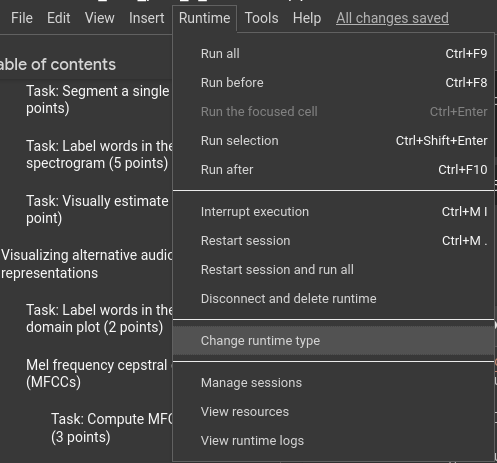

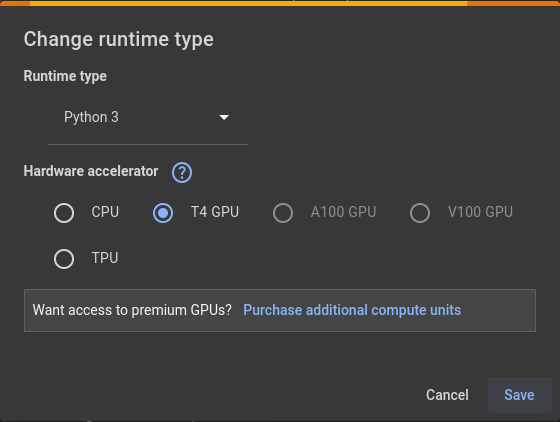

If you run out of memory, restart runtime session and try again.

In [ ]:
from transformers import AutoProcessor, BarkModel
from IPython.display import Audio
import matplotlib.pyplot as plt
import librosa
import librosa.display
import numpy as np

processor = AutoProcessor.from_pretrained("suno/bark")
model = BarkModel.from_pretrained("suno/bark").to("cuda")
model.cuda()

voice_preset = "v2/en_speaker_6"


In [ ]:
# process and move inputs to CUDA
inputs = processor("Back in my day, I had to walk to school uphill... both ways", voice_preset=voice_preset)
inputs = {k: v.to("cuda") for k, v in inputs.items()}

# generate audio
bark_audio_array = model.generate(**inputs)

# move output to CPU for further processing
bark_audio_array = bark_audio_array.cpu().numpy().squeeze()
bark_sr = model.generation_config.sample_rate

Audio(data=bark_audio_array, rate=bark_sr)

Now let's visualize the audio with waveshow and a melspectrogram.

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

visualize_waveform(bark_audio_array, sr=bark_sr, ax=axes[0])
generate_mel_spectrogram(bark_audio_array, sr=bark_sr, ax=axes[1])

plt.tight_layout()
plt.show()

### Task: Compare to normal TTS systems (10 points)

Use Bark to generate at least one utterance with the same transcript as some of your Coqui or Rime utterances. Visualize the Bark samples you generate as a spectrogram.



In [ ]:
# Generate at least 1 sample for Bark. Visualize the utterance in a spectrogram

#############################
#### YOUR CODE GOES HERE ####



#############################


Comment on Bark vs traditional TTS approaches. Does Bark sound better as a TTS system in terms of naturalness? Expressiveness? Does Bark always remain faithful to the input transcript? You do not need to perform a full listening test comparison.

```
Your response here
```

### Task: Generate audio that a normal TTS can't produce (5 points)

Bark can do much more than a standard TTS system. Think of an application where you might want a mix of speech and other sounds, or heavily modified prosody. Generate at least one sample with Bark that a normal TTS system would not produce, and describe how Bark might support the application / use case you picked.

In [ ]:
# Generate at least 1 sample for Bark. Visualize the utterance in a spectrogram

#############################
#### YOUR CODE GOES HERE ####


#############################

Comment on applications where you might prefer Bark over traditional TTS.

```
Your response here
```